## 1622 Assignment 3

In [42]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import matplotlib.pyplot as plt


Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [43]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #
# Define 50 credit drivers
Ndrivers = len(rho) 

# if Path(filename_save_out+'.npz').is_file():
#     Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
if Path('Losses_out_1.npy').is_file():
    Losses_out = np.load('Losses_out_1.npy')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    # Define parameter y for 100000 scenarios and 50 drivers
    y = np.zeros((Nout, Ndrivers))
    # Define creditworthiness index for 10000 scenarios and 100 counterparties
    w = np.zeros((Nout, K))
    # Define losses for 10000 scenarios and 100 counterparties
    Losses_out = np.zeros((Nout, K))
    # Define parameter z for each counterparty
    z = np.random.randn(K,1)
    
    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        normal_random_vector = np.random.randn(Ndrivers,1)
        y[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T
        
        for k in range(1, K + 1):
            # compute corresponding credit driver for counterparty k
            credit_driver = int(driver[k-1])
            # compute creditworthiness
            w[s-1, k-1] = beta[k-1] * y[s-1, credit_driver-1] + np.sqrt(1 - beta[k-1]**2) * z[k-1]
            temp = np.append(w[s-1, k-1], CS_Bdry[k-1,:])
            temp = np.sort(temp)
            credit_index = np.argwhere(temp == w[s-1, k-1])
            # compute out-of-sample losses (100000 x 100)
            Losses_out[s-1,k-1] = exposure[k-1, credit_index]        
    np.save('Losses_out_1.npy',Losses_out)  

In [44]:
# Normal approximation computed from out-of-sample scenarios
import math
import scipy.stats as scs
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

# Out-of-sample and In-sample
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # Sort loss data in increasing order
        Losses = np.sort(np.dot(Losses_out,x0[portN]))
        # Compute out-of-sample VaR and CVaR from the data
        VaRout[portN, q] = Losses[int(math.ceil(Nout * alf))-1]
        CVaRout[portN, q] = (1 / (Nout * (1-alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN,q]
                                                      + sum(Losses[int(math.ceil(Nout * alf)):]))
        # Compute in-sample VaR and CVaR from the data
        VaRinN[portN, q] = np.mean(Losses) + scs.norm.ppf(alf) * np.std(Losses)        
        CVaRinN[portN, q] = np.mean(Losses) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(Losses)

In [45]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

# In-sample N1, N2, MC1, MC2 
for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


In [46]:
%%time
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    # Define number of scenarios
    N_inMC1 = np.int(np.ceil(Nin / Ns))
    # Define parameter y for 1000 scenarios and 50 drivers
    y_inMC1 = np.zeros((N_inMC1,Ndrivers))
    # Define losses for 1000 scenarios and 50 drivers
    Losses_inMC1 = np.zeros((Nin,K))
    # Define parameter z for each counterparty
    z_inMC1 = np.random.randn(K,1)

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # 1000 systemic scenarios = 5000/5
        # -------- Insert your code here -------- #      
        normal_random_vector = np.random.randn(Ndrivers,1)
        y_inMC1[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T
        
        for si in range(1, Ns + 1): # 5 idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #  
            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1
            for k in range(1, K+1): #100        
                # compute corresponding credit driver
                credit_driver = int(driver[k-1])
                # compute credit worthiness index 
                w_inMC1 = beta[k-1] * y_inMC1[s-1, credit_driver-1] + np.sqrt(1 - beta[k-1]**2) * z_inMC1[k-1]
                # w and credist-state boundaries
                temp_MC1 = np.append(w_inMC1, CS_Bdry[k-1,:])
                # sort the credit map from the lowest
                temp_MC1 = np.sort(temp_MC1)
                # find the index
                credit_index = np.argwhere(temp_MC1 == w_inMC1)
                # compute in-sample losses (1000 x 5 x 100)
                Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1, credit_index]
                        
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 2
    # -------- Insert your code here -------- #
    # Define parameter y for scenarios and drivers
    y_inMC2 = np.zeros((Nin, Ndrivers))
    # Define losses for scenarios and drivers
    Losses_inMC2 = np.zeros((Nin, K))
    # Define parameter z for each counterparty
    z_inMC2 = np.random.randn(K, 1)

    for s in range(1, Nin + 1): # 5000 systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        normal_random_vector = np.random.randn(Ndrivers, 1)
        y_inMC2[s-1,:] = np.dot(sqrt_rho, normal_random_vector).T
                                          
        # Calculated losses for MC2 approximation (5000 x 100)
        # Losses_inMC2
        for k in range(1, K+1): #100   
            # compute corresponding credit driver
            credit_driver = int(driver[k-1])
            # compute credit worthiness index 
            w_inMC2 = beta[k-1] * y_inMC2[s-1, credit_driver-1] + np.sqrt(1 - beta[k-1]**2) * z_inMC2[k-1]
            # w and credist-state boundaries
            temp_MC2 = np.append(w_inMC2, CS_Bdry[k-1,:])
            # sort the credit map from the lowest
            temp_MC2 = np.sort(temp_MC2)
            # find the index
            credit_index = np.argwhere(temp_MC2 == w_inMC2)
            # compute in-sample losses (5000 x 100)
            Losses_inMC2[s-1,k-1] = exposure[k-1, credit_index]
                

    # Compute VaR and CVaR
    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
                                          
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
                                          
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
                                          
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
                                          
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
                                          
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2

# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $16070093.06, CVaR 99.0% = $26359318.16
In-sample MC1: VaR 99.0% = $20380026.76, CVaR 99.0% = $25926926.46
In-sample MC2: VaR 99.0% = $28928589.71, CVaR 99.0% = $35599556.73
In-sample No: VaR 99.0% = $10947305.67, CVaR 99.0% = $12336799.03
In-sample N1: VaR 99.0% = $15286785.04, CVaR 99.0% = $16637551.11
In-sample N2: VaR 99.0% = $21206929.49, CVaR 99.0% = $23498953.04

Out-of-sample: VaR 99.9% = $41439608.28, CVaR 99.9% = $50505477.31
In-sample MC1: VaR 99.9% = $33674909.66, CVaR 99.9% = $34218349.00
In-sample MC2: VaR 99.9% = $43572083.55, CVaR 99.9% = $50519392.23
In-sample No: VaR 99.9% = $14079550.46, CVaR 99.9% = $15214782.79
In-sample N1: VaR 99.9% = $18331729.41, CVaR 99.9% = $19435321.10
In-sample N2: VaR 99.9% = $26373689.56, CVaR 99.9% = $28246299.62


Portfolio 2:

Out-of-sample: VaR 99.0% = $20362818.34, CVaR 99.0% = $27602915.38
In-sample MC1: VaR 99.0% = $23575049.06, CVaR 99.0% = $27735330.25
In-sample MC2: VaR 99.0% = $25150296

### Portfolio 1 - Out-of-sample vs In-sample

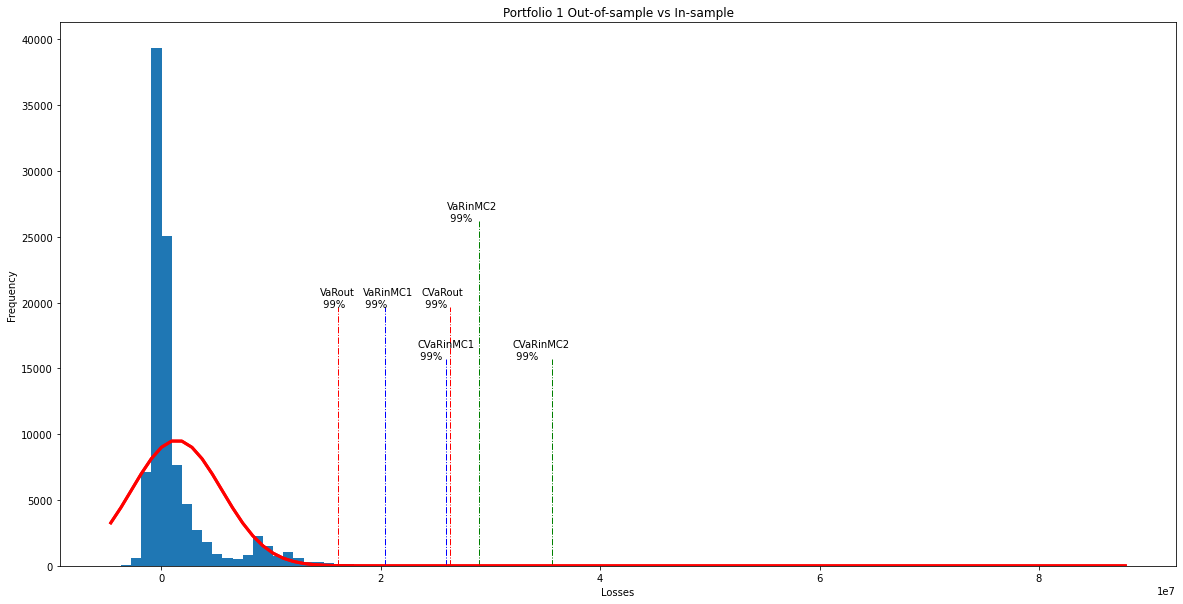

In [92]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
# Out-of-sample
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 2, 'VaRout\n 99%')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2, 'CVaRout\n 99%')

# In-sample
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2, 'VaRinMC1\n 99%')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2.5, 'CVaRinMC1\n 99%')
# In-sample
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/1.5], color='g', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2.5], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 1.5, 'VaRinMC2\n 99%')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.5, 'CVaRinMC2\n 99%')
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.title('Portfolio 1 Out-of-sample vs In-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Portfolio 2 - Out-of-sample vs In-sample

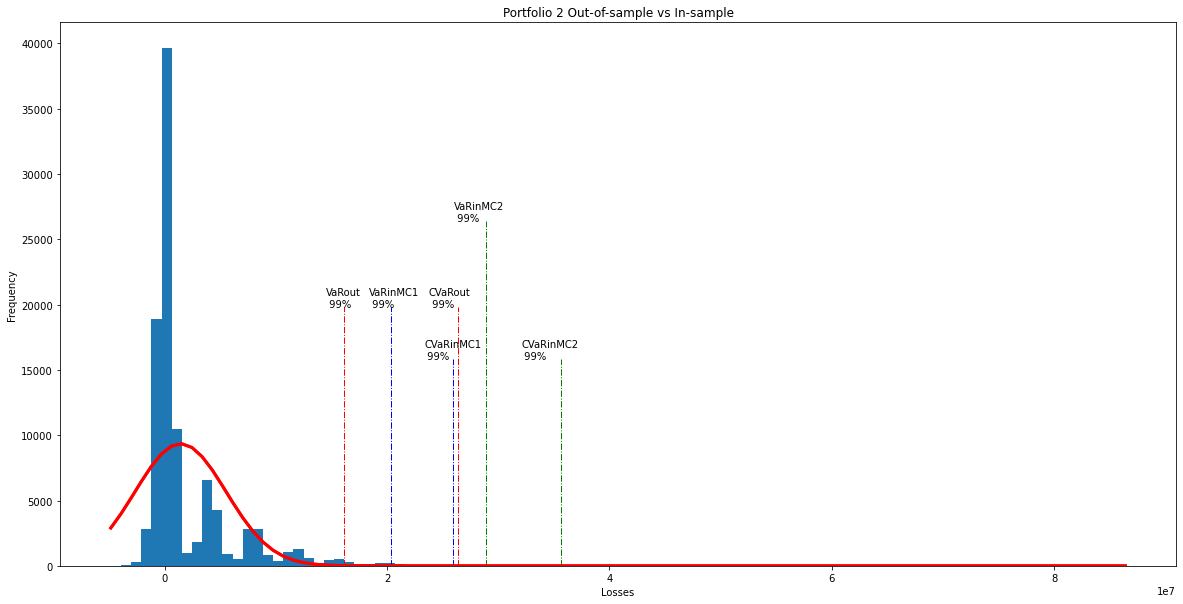

In [95]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
# Out-of-sample
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 2, 'VaRout\n 99%')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2, 'CVaRout\n 99%')

# In-sample
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2, 'VaRinMC1\n 99%')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2.5, 'CVaRinMC1\n 99%')
# In-sample
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/1.5], color='g', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2.5], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 1.5, 'VaRinMC2\n 99%')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.5, 'CVaRinMC2\n 99%')
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.title('Portfolio 2 Out-of-sample vs In-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 1 - out of sample vs normal model at 99% and 99.9% quantile level

Text(0, 0.5, 'Frequency')

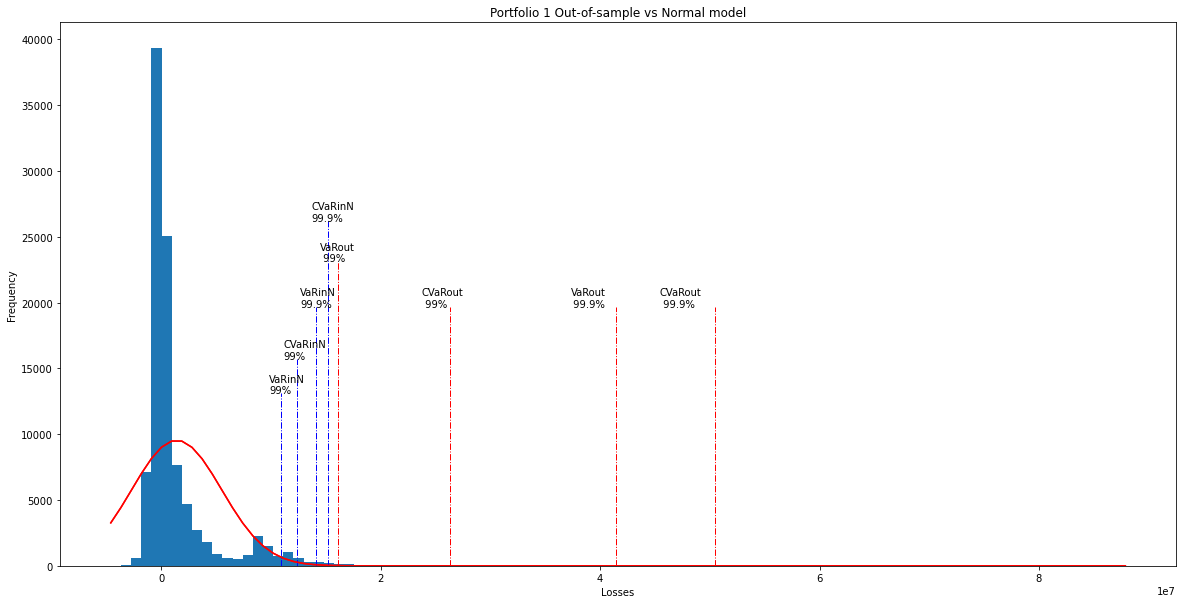

In [88]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/1.7], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 1.7, 'VaRout\n 99%')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 2, 'VaRout\n 99.9%')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2, 'CVaRout\n 99%')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRout[0,1], max(frequencyCounts) / 2, 'CVaRout\n 99.9%')

plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/3], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0,0], max(frequencyCounts) / 3, 'VaRinN\n99%')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0,1], max(frequencyCounts) / 2, 'VaRinN\n99.9%')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRinN[0,0], max(frequencyCounts) / 2.5, 'CVaRinN\n99%')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRinN[0,1], max(frequencyCounts) / 1.5, 'CVaRinN\n99.9%')
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.title('Portfolio 1 Out-of-sample vs Normal model')
plt.xlabel('Losses')
plt.ylabel('Frequency')

### Distribution of Portfolio 2 - out of sample vs normal model at 99% and 99.9% quantile level

Text(0, 0.5, 'Frequency')

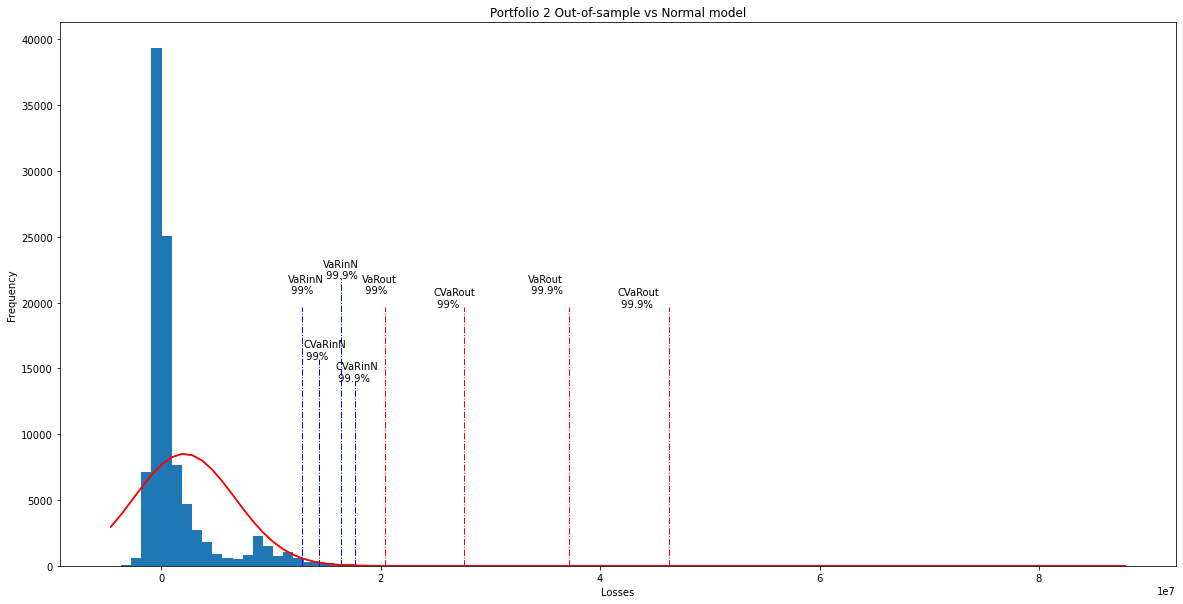

In [89]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]),100)
normf= (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout\n 99%')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout\n 99.9%')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRout[1,0], max(frequencyCounts) / 2, 'CVaRout\n 99%')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRout[1,1], max(frequencyCounts) / 2, 'CVaRout\n 99.9%')

plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1,0], max(frequencyCounts) / 1.9, 'VaRinN\n 99%')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1.8], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1,1], max(frequencyCounts) / 1.8, 'VaRinN\n 99.9%')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRinN[1,0], max(frequencyCounts) / 2.5, 'CVaRinN\n 99%')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2.8], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaRinN[1,1], max(frequencyCounts) / 2.8, 'CVaRinN\n 99.9%')
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.title('Portfolio 2 Out-of-sample vs Normal model')
plt.xlabel('Losses')
plt.ylabel('Frequency')

### Distribution of Portfolio 1 - out of sample

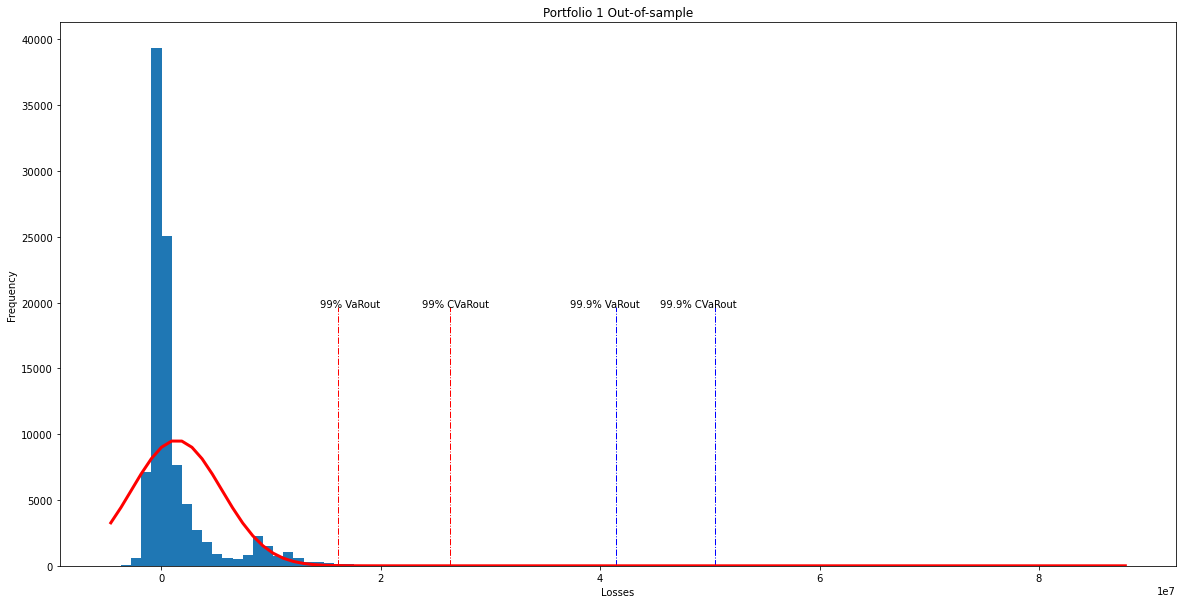

In [75]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 2, '99% VaRout')
plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 2, '99.9% VaRout')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2, '99% CVaRout')
plt.text(0.9 * CVaRout[0,1], max(frequencyCounts) / 2, '99.9% CVaRout')
plt.title('Portfolio 1 Out-of-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 1 - Monte Carlo Approximation 1

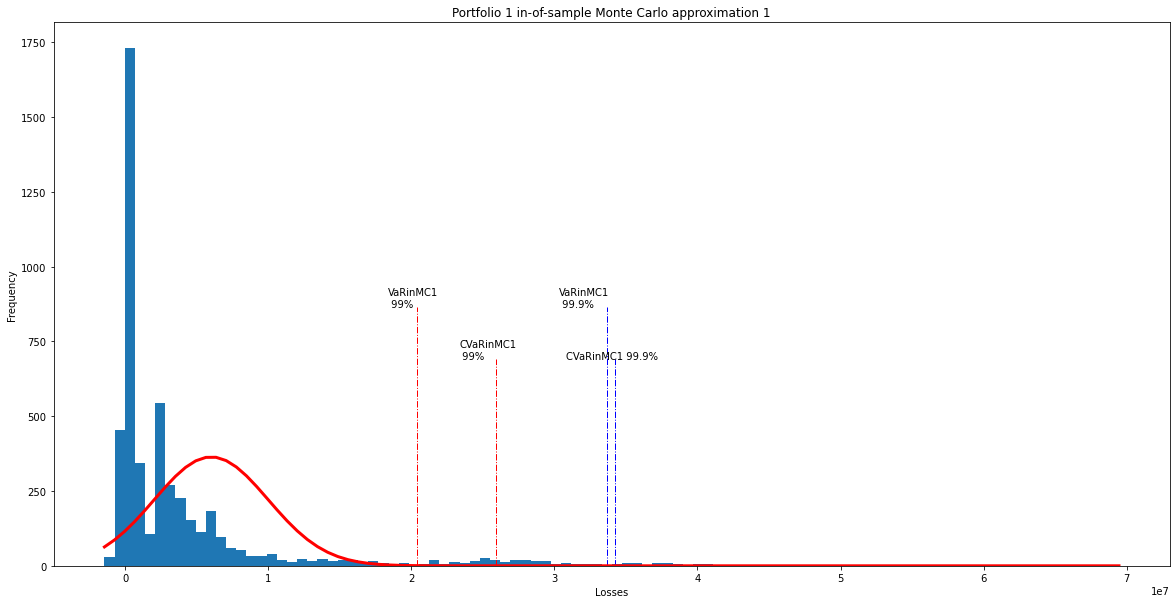

In [83]:
plt.figure(figsize=(20,10))
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2, 'VaRinMC1\n 99%')
plt.text(0.9 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 2, 'VaRinMC1\n 99.9%')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2.5, 'CVaRinMC1\n 99%')
plt.text(0.9 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts) / 2.5, 'CVaRinMC1 99.9%')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 1 - Monte Carlo Approximation 2

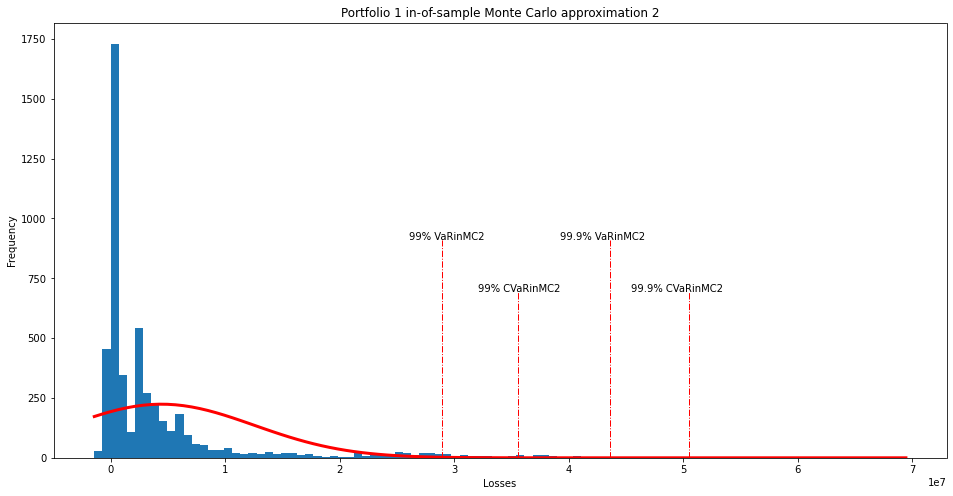

In [77]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/1.9], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/1.9], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 2 - out of sample

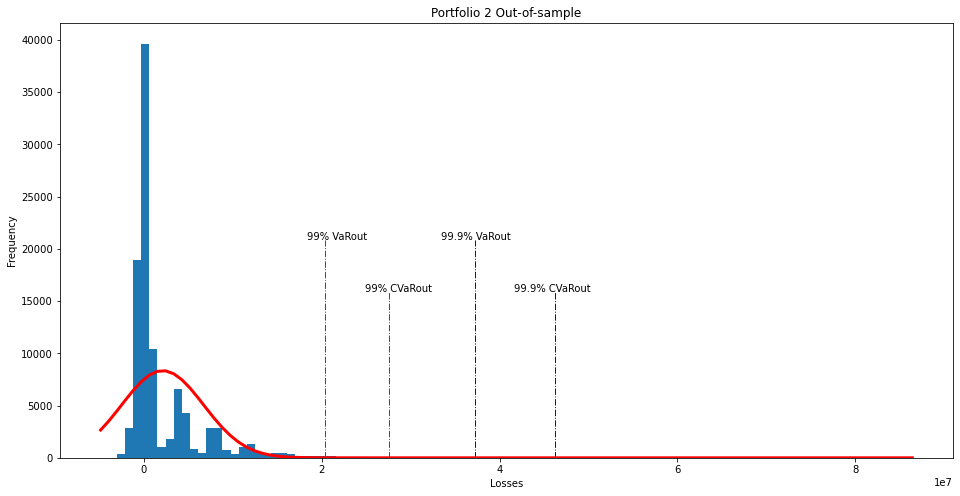

In [78]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/1.9], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/1.9], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[1,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[1,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * CVaRout[1,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRout[1,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.title('Portfolio 2 Out-of-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 2 - Monte Carlo Approximation 1

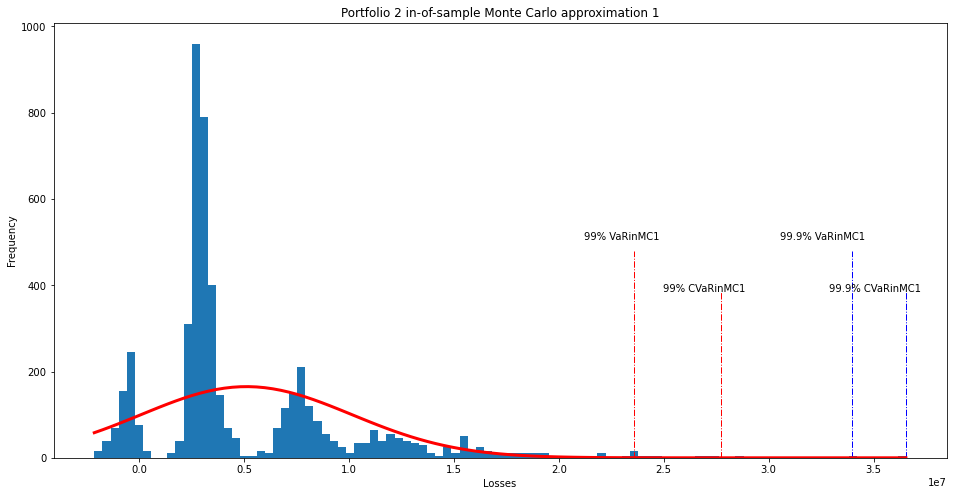

In [79]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[1]), 100)

normf= (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Distribution of Portfolio 2 - Monte Carlo Approximation 2

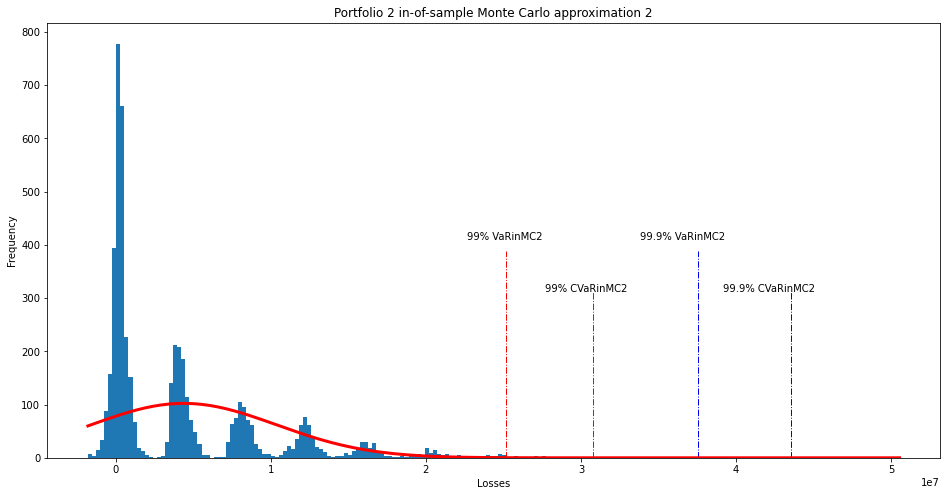

In [80]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2.5], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

### Average and Standard deviation of Portfolio 1 

In [81]:
# portfolio 1
print ("Average of out of sample for Portfolio 1 = ", np.mean(np.sort(np.dot(Losses_out,x0[0]))))
print ("Standard deviation of out of sample for Portfolio 1 = ", np.std(np.sort(np.dot(Losses_out,x0[0]))))
print ("Average of Monte Carlo approximation 1 for Portfolio 1 = ", np.mean(np.sort(np.dot(Losses_inMC1,x0[0]))))
print("Standard deviation of Monte Carlo approximation 1 for Portfolio 1 = ", np.std(np.sort(np.dot(Losses_inMC1,x0[0]))))
print ("Average of Monte Carlo approximation 2 for Portfolio 1 = ", np.mean(np.sort(np.dot(Losses_inMC2,x0[0]))))
print("Standard deviation of Monte Carlo approximation 2 for Portfolio 1 = ", np.std(np.sort(np.dot(Losses_inMC2,x0[0]))))

Average of out of sample for Portfolio 1 =  1408309.078233
Standard deviation of out of sample for Portfolio 1 =  4100417.0955877756
Average of Monte Carlo approximation 1 for Portfolio 1 =  6013654.7441799985
Standard deviation of Monte Carlo approximation 1 for Portfolio 1 =  3986132.252724751
Average of Monte Carlo approximation 2 for Portfolio 1 =  4418467.49844
Standard deviation of Monte Carlo approximation 2 for Portfolio 1 =  8110941.065452537


### Average and Standard deviation of Portfolio 2

In [82]:
# portfolio 2
print ("Average of out of sample for Portfolio 2 = ", np.mean(np.sort(np.dot(Losses_out,x0[1]))))
print ("Standard deviation of out of sample for Portfolio 2 = ", np.std(np.sort(np.dot(Losses_out,x0[1]))))
print ("Average of Monte Carlo approximation 1 for Portfolio 2 = ", np.mean(np.sort(np.dot(Losses_inMC1,x0[1]))))
print("Standard deviation of Monte Carlo approximation 1 for Portfolio 2 = ", np.std(np.sort(np.dot(Losses_inMC1,x0[1]))))
print ("Average of Monte Carlo approximation 2 for Portfolio 2 = ", np.mean(np.sort(np.dot(Losses_inMC2,x0[1]))))
print("Standard deviation of Monte Carlo approximation 2 for Portfolio 2 = ", np.std(np.sort(np.dot(Losses_inMC2,x0[1]))))

Average of out of sample for Portfolio 2 =  2104260.5671945796
Standard deviation of out of sample for Portfolio 2 =  4609514.4707868565
Average of Monte Carlo approximation 1 for Portfolio 2 =  5113692.431853115
Standard deviation of Monte Carlo approximation 1 for Portfolio 2 =  5023123.3007098185
Average of Monte Carlo approximation 2 for Portfolio 2 =  4385910.854735208
Standard deviation of Monte Carlo approximation 2 for Portfolio 2 =  5972479.22545801
